<div class="alert alert-block alert-success">
<h1><b>PROJET 8 - </b>Participez à la conception d'une voiture autonome</h1>
<h2>Notebook Scripts</h2></div>

<img src="future_vision_transport.png" width="250" height="250">

## Sommaire<hr>
[INTRODUCTION & PRESENTATION](#section_0)<br>
[A - IMPORTATIONS, DATA COLLECTION & INITIAL DATAFRAME](#section_0A)<br>
[B - EXPLORATORY DATA ANALYSIS](#section_0B)<br>
[C - TEXT PREPROCESSING](#section_0C)<br>
[D - WORD EMBEDDINGS](#section_0D)<br>
&emsp;[1 - Our own Word2Vec](#section_0D1)<br>
&emsp;[2 - Google's Word2Vec](#section_0D2)<br>
&emsp;[3 - GloVe word embeddings](#section_0D3)<br>
&emsp;[4 - FastText](#section_0D4)<br>
[E - DATA AND DATASET PREPARATION FOR ALGORITHMS](#section_0E)<br>
[F - PERFORMANCE METRICS DEFINITION](#section_0F)<br><hr>

<h2><div class="alert alert-block alert-success" id="section_0">
INTRODUCTION & PRESENTATION</div></h2>

<h3><div class="alert alert-block alert-info" id="section_0A">
<b>A - </b>IMPORTATIONS, DATA COLLECTION & INITIAL DATAFRAME</div></h3>

In [1]:
%matplotlib inline

# Importation of Python modules and methods.
import os
# import random
import time
import warnings
from pprint import pprint

# Importation of Machine Learning libraries.
import matplotlib.pyplot as plt
import numpy as np
# import pickle5 as pickle
import Augmentor
import tqdm

# Importation of TensorFlow/Keras functions or classes.
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.callbacks import (
    Callback, 
    EarlyStopping, 
    ModelCheckpoint, 
    ReduceLROnPlateau,
    TensorBoard, 
)
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import (
    Activation, 
    BatchNormalization, 
    concatenate, 
    Conv2D,
    Conv2DTranspose, 
    Dropout, 
    Lambda, 
    MaxPooling2D, 
    Permute,
    Reshape, 
    UpSampling2D
)
from tensorflow.keras.losses import binary_crossentropy, BinaryCrossentropy
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adadelta, Nadam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model, Sequence

# Importation of Image Augmentation libraries.
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, 
    HorizontalFlip, Rotate
)
import cv2
import imgaug as ia
import imgaug.augmenters as iaa
import Augmentor

# from multiclassunet import Unet
# from moviepy.editor import VideoFileClip, ImageSequenceClip

# from dilatednet import DilatedNet

# os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

<h3><div class="alert alert-block alert-warning" id="section_0A1">
<b>1 - </b>IMAGE DATASETS</div></h3>

In [2]:
cat_dict = {'void': [0, 1, 2, 3, 4, 5, 6],  # why 7 instead of 3 ?
            'flat': [7, 8, 9, 10],
            'construction': [11, 12, 13, 14, 15, 16],
            'object': [17, 18, 19, 20],
            'nature': [21, 22],
            'sky': [23],
            'human': [24, 25],
            'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]  # -1 ??
           }

|Group|Classes|
|---|---|
|flat|road · sidewalk · parking+ · rail track+|
|human|person* · rider*|
|vehicle|car* · truck* · bus* · on rails* · motorcycle* · bicycle* · caravan*+ · trailer*+|
|construction|building · wall · fence · guard rail+ · bridge+ · tunnel+|
|object|pole · pole group+ · traffic sign · traffic light|
|nature|vegetation · terrain|
|sky|sky|
|void|ground+ · dynamic+ · static+|

  \* *Single instance annotations are available. However, if the boundary between such instances cannot be clearly seen, the whole crowd/group is labeled together and annotated as group, e.g. car group.*
  <br>\+ *This label is not included in any evaluation and treated as void (or in the case of license plate as the vehicle mounted on).*

In [3]:
image_dir = 'datasets/images/train/aachen'
mask_dir = 'datasets/masks/train/aachen'
image_list = os.listdir(image_dir)
mask_list = os.listdir(mask_dir)
image_list.sort()
mask_list.sort()
print('Elements in image_list:')
pprint(image_list[:8])
print('\nElements in mask_list:')
pprint(mask_list[:8])
mask_color_list = [image for image in mask_list if image.endswith('color.png')]
print('\nColor masks in mask_color_list:')
pprint(mask_color_list[:8])
print(f'\nNumber of images: {len(image_list)}\nNumber of color masks: {len(mask_color_list)}')

# Checking of the number of images and respected color masks.
for i in range(len(image_list)):
    assert image_list[i][:-16] == mask_color_list[i][:-17]
print(f'\n{image_list[5]} \n{mask_color_list[5]}')

Elements in image_list:
['aachen_000000_000019_leftImg8bit.png',
 'aachen_000001_000019_leftImg8bit.png',
 'aachen_000002_000019_leftImg8bit.png',
 'aachen_000003_000019_leftImg8bit.png',
 'aachen_000004_000019_leftImg8bit.png',
 'aachen_000005_000019_leftImg8bit.png',
 'aachen_000006_000019_leftImg8bit.png',
 'aachen_000007_000019_leftImg8bit.png']

Elements in mask_list:
['aachen_000000_000019_gtFine_color.png',
 'aachen_000000_000019_gtFine_instanceIds.png',
 'aachen_000000_000019_gtFine_labelIds.png',
 'aachen_000000_000019_gtFine_polygons.json',
 'aachen_000001_000019_gtFine_color.png',
 'aachen_000001_000019_gtFine_instanceIds.png',
 'aachen_000001_000019_gtFine_labelIds.png',
 'aachen_000001_000019_gtFine_polygons.json']

Color masks in mask_color_list:
['aachen_000000_000019_gtFine_color.png',
 'aachen_000001_000019_gtFine_color.png',
 'aachen_000002_000019_gtFine_color.png',
 'aachen_000003_000019_gtFine_color.png',
 'aachen_000004_000019_gtFine_color.png',
 'aachen_000005_000

/Users/jean-francoissubrini/opt/anaconda3/envs/env_p8/lib/python3.10/site-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


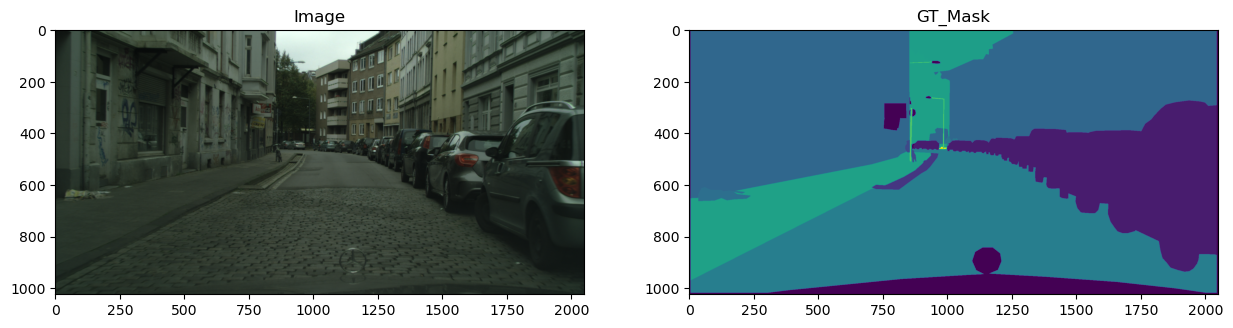

In [4]:
i = 40
test_image = image.img_to_array(
    image.load_img(f'{image_dir}/{image_list[i]}')) / 255.
test_mask = image.img_to_array(
    image.load_img(f'{mask_dir}/{mask_color_list[i]}', grayscale=True))
test_mask = np.squeeze(test_mask)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('Image')
ax.imshow(test_image)

ax1 = fig.add_subplot(1, 2, 2)
ax1.set_title('GT_Mask')
ax1.imshow(test_mask)

In [5]:
def get_mask(mask_list):
    for m in tqdm.tqdm(tmask_list):
        img = image.load_img(f'{train_dir}/{m}', grayscale=True, target_size=(512, 512))
        img = np.squeeze(image.img_to_array(img))

In [6]:
def make_mask(img):
    mask = np.zeros((img.shape[0], img.shape[1], 8))
    for i in range(-1, 34):
        if i in cats['void']:
            mask[:,:,0] = np.logical_or(mask[:,:,0],(img==i))
        elif i in cats['flat']:
            mask[:,:,1] = np.logical_or(mask[:,:,1],(img==i))
        elif i in cats['construction']:
            mask[:,:,2] = np.logical_or(mask[:,:,2],(img==i))
        elif i in cats['object']:
            mask[:,:,3] = np.logical_or(mask[:,:,3],(img==i))
        elif i in cats['nature']:
            mask[:,:,4] = np.logical_or(mask[:,:,4],(img==i))
        elif i in cats['sky']:
            mask[:,:,5] = np.logical_or(mask[:,:,5],(img==i))
        elif i in cats['human']:
            mask[:,:,6] = np.logical_or(mask[:,:,6],(img==i))
        elif i in cats['vehicle']:
            mask[:,:,7] = np.logical_or(mask[:,:,7],(img==i))
    mask = np.resize(mask,(img.shape[0]*img.shape[1], 8))
    return mask

<h3><div class="alert alert-block alert-warning" id="section_0A2">
<b>2 - </b>IMAGE AUGMENTATION</div></h3>

In [7]:
image_dir = 'datasets/images/train/aachen'
mask_dir = 'datasets/masks/train/aachen'
image_list = os.listdir(image_dir)
mask_list = os.listdir(mask_dir)
image_list.sort()
mask_list.sort()
print('Elements in image_list:')
pprint(image_list[:8])
print('\nElements in mask_list:')
pprint(mask_list[:8])
mask_color_list = [image for image in mask_list if image.endswith('color.png')]
print('\nColor masks in mask_color_list:')
pprint(mask_color_list[:8])
print(f'\nNumber of images: {len(image_list)}\nNumber of color masks: {len(mask_color_list)}')

# # Checking of the number of images and respected color masks.
# for i in range(len(image_list)):
#     assert image_list[i] == mask_color_list[i]
print(f'\n{image_list[5]} \n{mask_color_list[5]}')

Elements in image_list:
['aachen_000000_000019_leftImg8bit.png',
 'aachen_000001_000019_leftImg8bit.png',
 'aachen_000002_000019_leftImg8bit.png',
 'aachen_000003_000019_leftImg8bit.png',
 'aachen_000004_000019_leftImg8bit.png',
 'aachen_000005_000019_leftImg8bit.png',
 'aachen_000006_000019_leftImg8bit.png',
 'aachen_000007_000019_leftImg8bit.png']

Elements in mask_list:
['aachen_000000_000019_gtFine_color.png',
 'aachen_000000_000019_gtFine_instanceIds.png',
 'aachen_000000_000019_gtFine_labelIds.png',
 'aachen_000000_000019_gtFine_polygons.json',
 'aachen_000001_000019_gtFine_color.png',
 'aachen_000001_000019_gtFine_instanceIds.png',
 'aachen_000001_000019_gtFine_labelIds.png',
 'aachen_000001_000019_gtFine_polygons.json']

Color masks in mask_color_list:
['aachen_000000_000019_gtFine_color.png',
 'aachen_000001_000019_gtFine_color.png',
 'aachen_000002_000019_gtFine_color.png',
 'aachen_000003_000019_gtFine_color.png',
 'aachen_000004_000019_gtFine_color.png',
 'aachen_000005_000

In [8]:
p = Augmentor.Pipeline('datasets/images/train/aachen', 
                       output_directory='../../aug_dataset/train/aachen')

Initialised with 174 image(s) found.
Output directory set to datasets/images/train/aachen/../../aug_dataset/train/aachen.

In [9]:
p.ground_truth('datasets/masks/train/aachen')
p.rotate(probability=1, max_left_rotation=10, max_right_rotation=10)
p.flip_left_right(probability=0.5)
p.zoom_random(probability=0.5, percentage_area=0.8)
p.skew(probability=0.5, magnitude=0.5)
p.skew_tilt(probability=0.5, magnitude=0.5)
p.random_distortion(probability=0.5,grid_height=4, grid_width=4, magnitude=4)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.gaussian_distortion(probability=0.5, corner='bell', method='in', grid_height=4, grid_width=4, magnitude=4)
p.skew_top_bottom(probability=0.5, magnitude=.5)
p.skew_left_right(probability=0.5, magnitude=.5)
p.skew_corner(probability=0.5, magnitude=.5)
p.resize(probability=1,width=256, height=256)

0 ground truth image(s) found.


In [10]:
p.sample(100)

Processing <PIL.Image.Image image mode=RGB size=256x256 at 0x28BDC7280>: 100%|█| 100/100 [00:07


<h3><div class="alert alert-block alert-info" id="section_0D">
<b>D - </b>PERFORMANCE METRICS DEFINITION</div></h3>

<img src="IoU.png" width="250" height="250">

<img src="Dice.png" width="250" height="250">

<h3><div class="alert alert-block alert-info" id="section_0E">
<b>E - </b>U-NET ARCHITECTURE</div></h3>

<img src="U-NET.png" width="500" height="500">